In [126]:
# @CX-REMOVE
import ipynbname
nb_name = ipynbname.path().name

In [127]:
%%script bash -s $nb_name
# @CX-REMOVE
#
# Export Notebook as Blogpost
#
./render.sh ./$1 ./nb.html
cat <<EOF > fm.html
---
title: Investment Calculator
date: 2023-08-12
url: /ic
outputs:
  - RawHTML
---
EOF

cat fm.html nb.html \
    > /host/root/home/hhartmann/src/HeinrichHartmann.github.io/hugo/content/posts/raw/ic.html

[NbConvertApp] Converting notebook ./InvestementCalculator.ipynb to HTML
[NbConvertApp] Writing 950768 bytes to nb.html


# Investment Calculator

<p class="meta" style="color:#aaa; float:right">Stemwede, 2022-08-12</p>
<br style="clear:both"/>

This note contains several "calculator" notebooks, that can be used to evaluate the value of investments.
They allow to model (a) investment cash flow (b) opportunity costs of investing the available equity elesewhere
(c) credit leverage and (d) inflation, and identify optimal ivestment strategies.

### Usage

- The source notbooks for these calculators are available on [GitHub](https://github.com/HeinrichHartmann/pub/blob/master/InvestementCalculator.ipynb).
- Launch Interactive Version on Binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HeinrichHartmann/pub/master?labpath=InvestementCalculator.ipynb)


### Example - Solar Plant

The example use-case we use in this post is a Solar Plant Investment with the following parameters:

- 20,000 EUR are the costs of the system.
- 1,250 EUR are the annual returns in reductions to my power bill, and gains from selling electricity.
- 30 years, is the expected lifetime the system.

The question we seek to answer is (a) Is this worth buying? and (2) How much credit should I take?

In [3]:
# Install Dependencies
# @CX-TOGGLE
# Run once, then comment out
# !pip install ipytest numpy pandas numpy_financial

In [114]:
# Source Code ...
# @CX-TOGGLE

from dataclasses import dataclass
import numpy as np
import numpy_financial as npf
import pandas as pd

from scipy.optimize import minimize, minimize_scalar
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
  
from IPython.display import display, HTML

import ipytest
import pytest
ipytest.autoconfig()

def P_EUR(num):
    print(f"{num:,.0f} EUR")
    
def P(num, unit):
    print(f"{num:,.1f} {unit}")
    
def p(text):
    print(text, end='')

class CashFlow(pd.Series):
   
    @classmethod
    def from_constant(cls, years, value):
        return cls(np.zeros(years + 1) + value)

    @classmethod
    def from_investment(cls, N, PV, PMT):
        cf = np.zeros(N + 1)
        cf[0] = -PV
        cf[1:] += PMT
        return cls(cf, name="Cash Flow")
    
    def pad(self, years):
        return CashFlow(self.copy().reindex(range(years + 1), fill_value = 0))

    def shift(self, n):
        return CashFlow(np.concatenate([[0]*n, self]))
    
    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        ax = super().plot(**kwargs)
        plt.title("Cash Flow Plot")
        plt.ylabel("Cash Flow/EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)
        return ax

    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return CashFlow( self * discount_factor )

    def present_value(self, interest_rate):
        return npf.npv(interest_rate, self)
    
    def neg(self):
        o = self.copy()
        o[ o > 0 ] = 0
        return CashFlow(o)
    
    def pos(self):
        o = self.copy()
        o[ o < 0 ] = 0
        return CashFlow(o)
    
    def roi(self):
        "Return on investment. Assumes that cash flow is already discounted."
        inv = -self.neg().sum() # sum all payments
        ret = self.pos().sum()  # value we gained until end
        return ret/inv

    def aroi(self):
        "Annualized return on investment. Assumes that cash flow is already discounted"
        return self.roi() ** (1./(len(self)-1)) - 1
    
    def __add__(self, other):
        l = max(len(self), len(other)) - 1
        return CashFlow( np.array(self.pad(l)) + np.array(other.pad(l)) )

# ValueSeries Implementation ...
class ValueSeries(pd.Series):
    "Represents the value of an asset over time."
    
    @classmethod
    def from_deposit(cls, years, amount):
        return cls(np.zeros(years + 1) + amount, name="Value Series")
    
    @classmethod
    def from_cash_flow(cls, cf : CashFlow):
        return cls(np.cumsum(cf), name="Value Series")
    
    def shift(self, n):
        return ValueSeries(np.concatenate([[self.iloc[0]]*n, self]))
    
    def pad(self, years):
        return ValueSeries(self.copy().reindex(range(years+1), fill_value = self.iloc[-1]))

    def with_interest(self, interest_rate):
        out = ValueSeries(self.copy())
        for i in range(1, len(out)):
            out[i:] += out[i-1] * interest_rate
        return out
        
    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return ValueSeries(self * discount_factor)
        
    def cash_flow(self, start_value = 0):
        cf = self.diff().fillna(0).copy()
        cf[0] = self[0] - start_value
        return CashFlow(cf)
    
    def roi(self):
        "Return on investment."
        inv = self.iloc[0] # investment = start value
        ret = self.iloc[-1] # return = end value
        return (ret)/inv

    def aroi(self):
        "Annualized return on investment. Assumes that cash flow is already discounted"
        return self.roi() ** (1./(len(self)-1)) - 1

    
    def total(self):
        return self.iloc[-1]
    
    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        ax = super().plot(**kwargs)
        plt.ylabel("EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)
        plt.ylabel("Accumulated Value")
        plt.title("Accumulated Value Plot")
        return ax
        
    def __add__(self, other):
        l = max(len(self), len(other)) - 1
        return ValueSeries( np.array(self.pad(l)) + np.array(other.pad(l)) )
    
    def __radd__(self, other):
        l = max(len(self), len(other)) - 1
        return ValueSeries( np.array(self.pad(l)) + np.array(other.pad(l)) )
    
# Credit Model ...

@dataclass
class Credit:
    amount : float
    years  : int
    interest : float

    def rate(self):
        return - npf.pmt(self.interest, self.years, self.amount)

    def cash_flow(self):
        if self.years == 0:
            return CashFlow(np.zeros(1))
        cf = np.zeros(self.years + 1)
        cf[0] = self.amount
        cf[1:] = - self.rate()
        return CashFlow(cf)
    
    def costs(self):
        return self.rate() * self.years
    
def H(s):
    display(HTML(s))

In [115]:
%%ipytest
# Tests...
# @CX-REMOVE
# 
def test_CashFlow():
    CF = CashFlow.from_investment(30, 20000, 1250) 
    assert CF.discount(0.05).sum() == CF.present_value(0.05)
    assert CF.discount(0).sum() == CF.sum()
    assert CF.present_value(0) == CF.sum()
    
    
def test_reverse():
    # Discounting reverses the effect
    AV = ValueSeries.from_deposit(30, 20000).with_interest(0.05).discount(0.05)
    assert ((AV - ValueSeries.from_deposit(30, 20000)).abs() < 1e-6).all()
    
def test_cc():
    "We can compute the total sum of credit cash flow with credit_costs"
    cf = Credit(20000, 10, 0.05).cash_flow()
    assert cf.neg().sum() == -Credit(20000, 10, 0.05).costs()

def test_discounted_cc():
    "Summing the discounted cash-flow gives close to zero value"
    cf = Credit(20000, 10, 0.05).cash_flow().discount(0.05)
    assert cf.sum() == pytest.approx(0, abs=1e-6)

....                                                                                         [100%]
4 passed in 0.04s


## Investment Calculator #1: <br> Investment Value vs. Opportunity Value

This calculator comparse the following two scenarios:

**A Investment (blue)**

- Spend 20,000 EUR (INV_COST) now, to get an annual return of 1,250 EUR (INV_ANNUAL_RETURN) payed out over 30 (INV_LIFETIME) years.
- Assume that the returns will depreciate with 0% inflation (INV_INFLATION).

**B Opportunity Costs (green)**

- Invest 20,000 EUR (INV_COST) into the stock market, and earn 5% (EQ_INTEREST) over the investment period (INV_LIFETIME).
- Assume that the investment value will depreciate with 2% inflation (EQ_INFLATION).


Investment A:
- Total investment costs:    20,000 EUR
- Present Value:             37,500 EUR
- Return on Investment:      1.875x (2.1% p.a.)
Investment B:
- Total investment costs:    20,000 EUR
- Present Value:             47,720 EUR
- Return on Investment:      2.386x (2.9% p.a.)


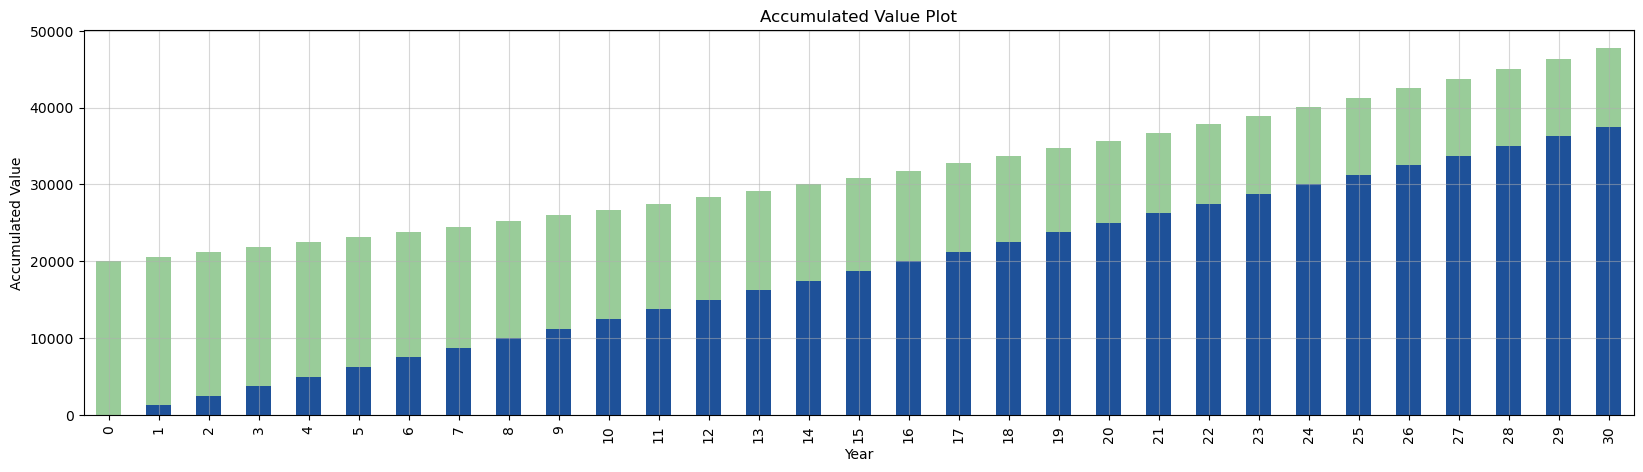

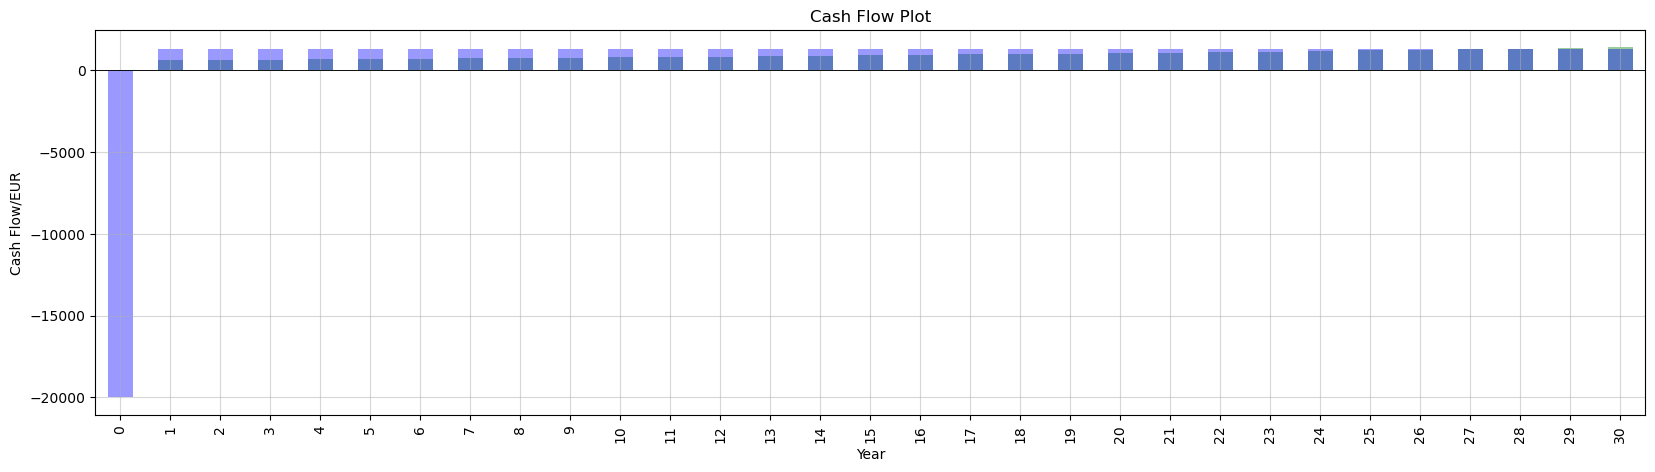

,A Investment Value,A Cash Flow,B Investment Value,B Cash Flow
Year,,,,
0,0,"-20,000","20,000",0
1,"1,250","1,250","20,588",588
2,"2,500","1,250","21,194",606
3,"3,750","1,250","21,817",623
4,"5,000","1,250","22,459",642
5,"6,250","1,250","23,119",661
6,"7,500","1,250","23,799",680
7,"8,750","1,250","24,499",700
8,"10,000","1,250","25,220",721


In [116]:
INV_COST = 20_000
INV_ANNUAL_RETURN = 1_250
INV_LIFETIME = 30
INV_INFLATION = 0.00

EQUITY = 20_000
EQ_INTEREST = 0.05
EQ_INFLATION = 0.02
# @CX-TOGGLE

A_CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN).discount(INV_INFLATION)
A_V = (ValueSeries.from_deposit(INV_LIFETIME, EQUITY) + ValueSeries.from_cash_flow(A_CF))

B_V = ValueSeries.from_deposit(INV_LIFETIME, EQUITY).with_interest(EQ_INTEREST).discount(EQ_INFLATION)
B_CF = B_V.cash_flow(EQUITY)

print("Investment A:");
p("- Total investment costs:    "); P_EUR( -A_CF.neg().sum() )
p("- Present Value:             "); P_EUR( A_V.total() )
p("- Return on Investment:      "); print(f"{A_CF.roi():.3f}x ({A_CF.aroi()*100:.1f}% p.a.)"); 

print("Investment B:");
p("- Total investment costs:    "); P_EUR( EQUITY )
p("- Present Value:             "); P_EUR( B_V.total() )
p("- Return on Investment:      "); print(f"{B_V.roi():.3f}x ({B_V.aroi()*100:.1f}% p.a.)");


A_V.plot(color="blue", alpha=0.8)
B_V.plot(color="green", alpha=0.4)
plt.grid(True, alpha=0.5)
plt.show()

B_CF.plot(color="green", alpha=0.4)
A_CF.plot(color="blue", alpha=0.4)
plt.grid(True, alpha=0.5)
plt.show()

df = pd.DataFrame({
  "A Investment Value" : A_V,
  "A Cash Flow": A_CF,
  "B Investment Value" : B_V,
  "B Cash Flow": B_CF
})
df.index.name = "Year"
def _fmt(val):
    return "{:,.0f}".format(val)

H("<br><br>")
H("<details><summary>Table</summary><center>" + df.style.format(_fmt).to_html(index=False) + "</center></details>")

## Investment Calculator #2:<br>Credit Leveraged Investment Value 

We have available equity of 5_000 EUR (EQUITY).

**A Investment (blue)**

- Spend 20_000 EUR (INV_COST) now, to get an annual return of 1_250 EUR (INV_ANNUAL_RETURN) payed out over 30 (INV_LIFETIME) years.
- Assume that the returns will depreciate with 0% inflation (INV_INFLATION).
- Finance the missing 15_000 EUR (CREDIT_AMOUNT), with a credit at 6% interest (CREDIT_INTEREST) running 10 years (CREDIT_YEARS).
- Assume that the returns will depreciate with 2% inflation (EQ_INFLATION).

**B Opportunity Costs (green)**

- Invest the equity 5_000 EUR (EQUITY) into the stock market, and earn 5% (EQ_INTEREST) over the investment period (INV_LIFETIME).
- Assume that the returns will depreciate with 2% inflation (EQ_INFLATION).

 TOTAL :  49156 EUR
Investment A:
- Total investment costs:    10,173 EUR
- Present Value:             25,296 EUR
- Return on Investment:      2.503x (3.1% p.a.)
Investment B:
- Total investment costs:    10,000 EUR
- Present Value:             23,860 EUR
- Return on Investment:      2.386x (2.9% p.a.)


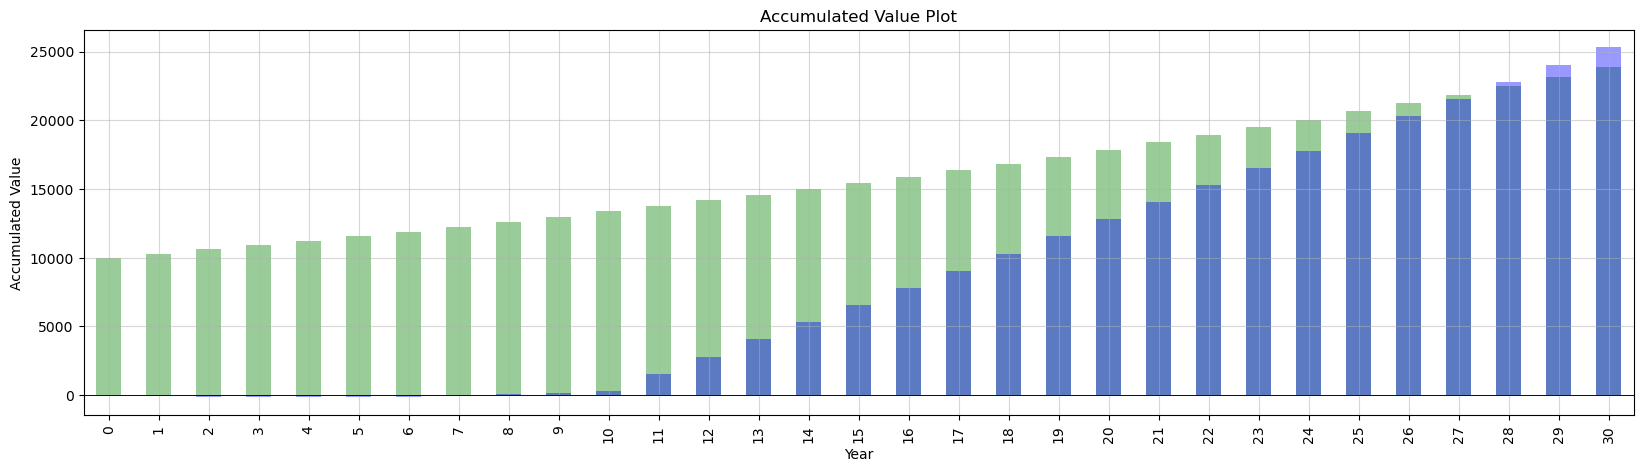

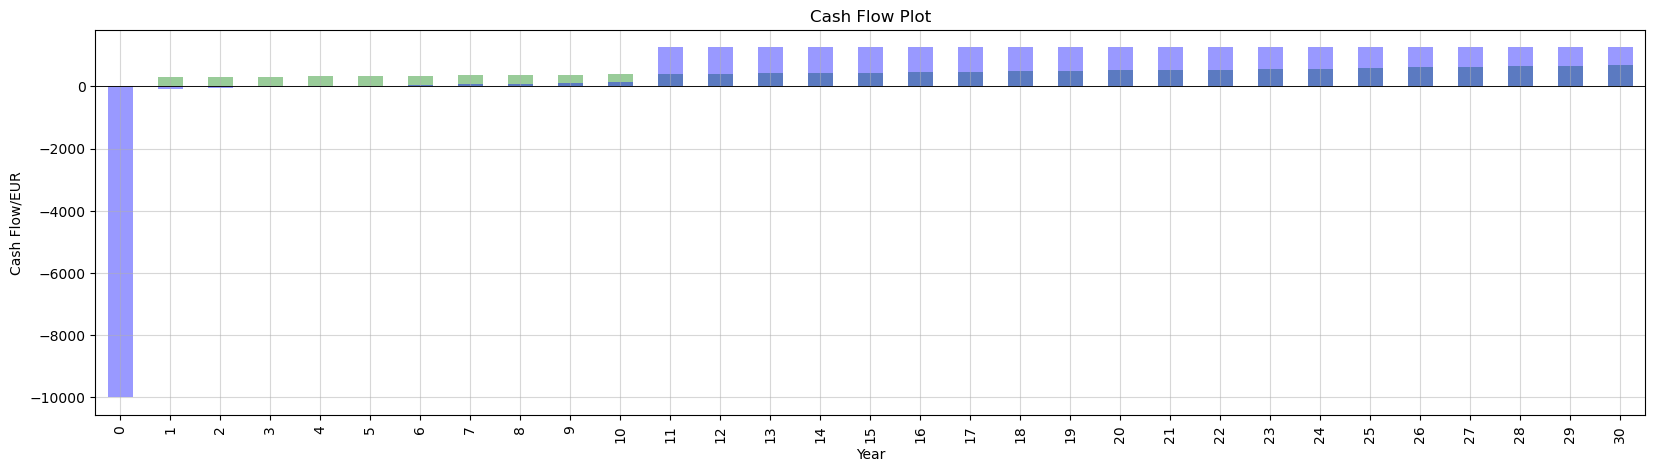

,A Investment Value,A Cash Flow,B Investment Value,B Cash Flow
Year,,,,
0,0,"-10,000","10,000",0
1,-82,-82,"10,294",294
2,-138,-56,"10,597",303
3,-168,-30,"10,909",312
4,-173,-5,"11,229",321
5,-154,19,"11,560",330
6,-111,44,"11,900",340
7,-43,67,"12,250",350
8,47,90,"12,610",360


In [117]:
EQUITY = 10_000

INV_COST = 20_000
INV_ANNUAL_RETURN = 1_250
INV_LIFETIME = 30
INV_INFLATION = 0.00

CREDIT_AMOUNT = INV_COST - EQUITY
CREDIT_YEARS = 10
CREDIT_INTEREST = 0.06

EQ_INFLATION = 0.02
EQ_INTEREST = 0.05
# @CX-TOGGLE

years = max(INV_LIFETIME, CREDIT_YEARS)

A_EQ = ValueSeries.from_deposit(years, EQUITY)
A_INV_CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN).discount(INV_INFLATION)
A_CRD_CF = Credit(CREDIT_AMOUNT, CREDIT_YEARS, CREDIT_INTEREST).cash_flow().discount(EQ_INFLATION)
A_CF = A_INV_CF + A_CRD_CF
A_V  = A_EQ + ValueSeries.from_cash_flow(A_CF)

B_EQ = ValueSeries.from_deposit(years, EQUITY)
B_CF = ValueSeries.from_deposit(INV_LIFETIME, EQUITY).with_interest(EQ_INTEREST).discount(EQ_INFLATION).cash_flow(start_value=EQUITY)
B_V  = B_EQ + ValueSeries.from_cash_flow(B_CF)

print(f" TOTAL :  { A_V.total() + B_V.total():.0f} EUR")

print("Investment A:");
p("- Total investment costs:    "); P_EUR( -A_CF.neg().sum() )
p("- Present Value:             "); P_EUR( A_V.total() )
p("- Return on Investment:      "); print(f"{A_CF.roi():.3f}x ({A_CF.aroi()*100:.1f}% p.a.)"); 
print("Investment B:");
p("- Total investment costs:    "); P_EUR( EQUITY )
p("- Present Value:             "); P_EUR( B_V.total() )
p("- Return on Investment:      "); print(f"{B_V.roi():.3f}x ({B_V.aroi()*100:.1f}% p.a.)");


ax = B_V.plot(color="green", alpha=0.4)
A_V.plot(color="blue", alpha=0.4)
plt.grid(True, alpha=0.5)
plt.show()

B_CF.plot(color="green", alpha=0.4)
A_CF.plot(color="blue", alpha=0.4)
plt.grid(True, alpha=0.5)
plt.show()

df = pd.DataFrame({
  "A Investment Value" : A_V,
  "A Cash Flow": A_CF,
  "B Investment Value" : B_V,
  "B Cash Flow": B_CF
})
df.index.name = "Year"
def _fmt(val):
    return "{:,.0f}".format(val)

H("<br><br>")
H("<details><summary>Table</summary><center>" + df.style.format(_fmt).to_html(index=False) + "</center></details>")

# Credit Optimization

When leveraging investments with a credit, we have two variables at hand, that we can control: the credit amount (CREDIT_AMOUNT) and the credit duration (CREDIT_YEARS).

What are the optimal choices?

For us _optimal_ means, that we optimize the (annualized) return of investment.

Note that additional equity may be required to pay the credit across the lifetime, so the total equity need may be larger than INV_COSTS - CREDIT_AMOUNT.

# Optimized Credit
        
credit amount        :               12,020 EUR
credit duration      :                   15 years
credit costs         :               21,064 EUR
total_equity         :                8,349 EUR
total_returns        :               19,825 EUR
return on investment :                2.375 x
                                      2.925 % p.a.
present_value        :               11,476 EUR



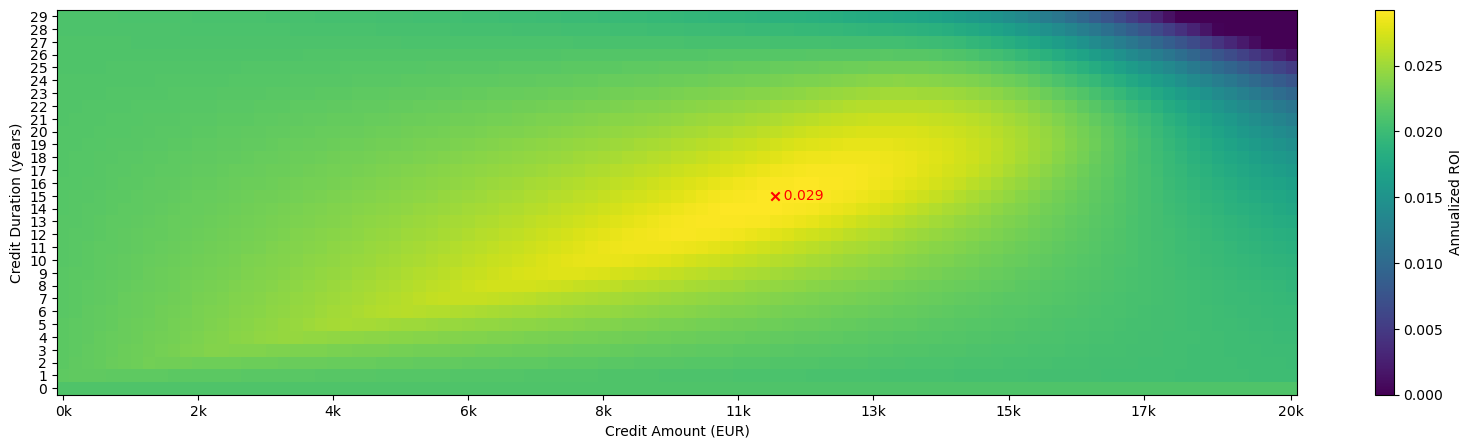

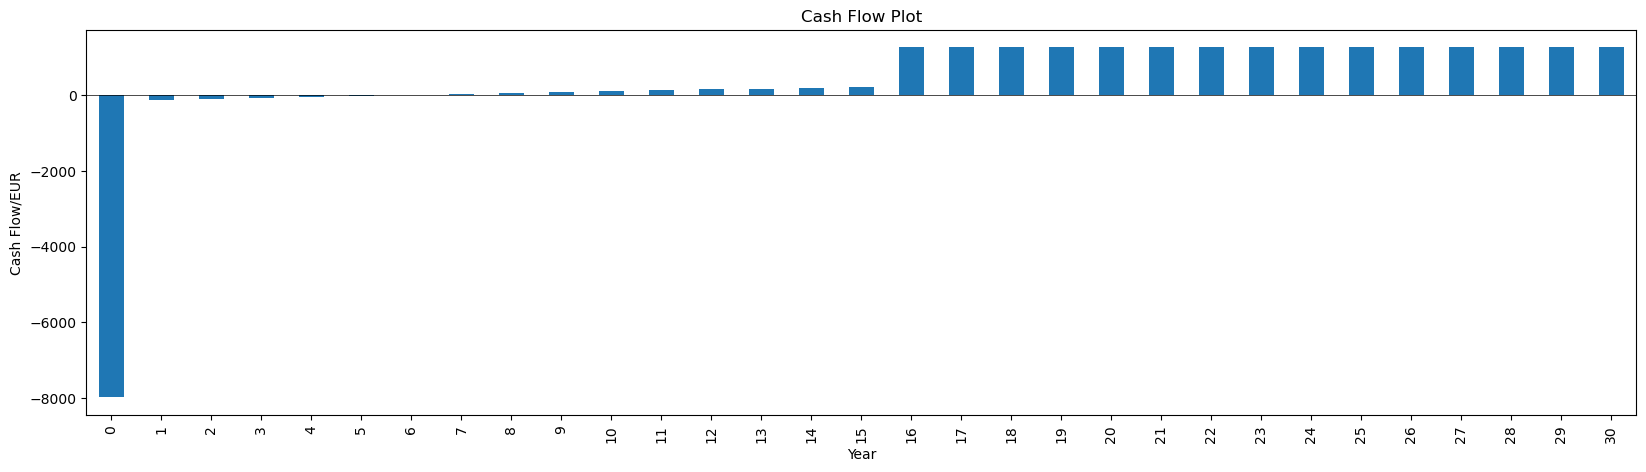

In [125]:
EQUITY_LIMIT = 30_000 # Maximal capital we are willing to put into this inve

INV_COST = 20_000
INV_ANNUAL_RETURN = 1_250
INV_LIFETIME = 30
INV_INFLATION = 0.00

CREDIT_INTEREST = 0.08
CREDIT_AMOUNT_RANGE = np.linspace(1_000, 20_000 ,101)
CREDIT_DURATION_RANGE = np.arange(0,30)

EQ_INFLATION = 0.02
EQ_INTEREST = 0.05
# @CX-TOGGLE
def opt_data(credit_amount, credit_years):
    years = max(INV_LIFETIME, credit_years)
    A_INV_CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN).discount(INV_INFLATION)
    credit = Credit(credit_amount, credit_years, CREDIT_INTEREST)
    A_CRD_CF = credit.cash_flow().discount(EQ_INFLATION)
    A_CF = A_INV_CF + A_CRD_CF
    if( -A_CF.neg().sum() > EQUITY_LIMIT):
        # We can't satisfy this cash flow with our available equity. Bail.
        return (0, A_CF, credit)
    return (A_CF.aroi(), A_CF, credit)

def opt_roi(*args):
    return opt_data(*args)[0]

@dataclass
class Optimizer:
    VAL: object
    best_ca: float
    best_cd: float
    max_roi: float
    credit: Credit
    cf: CashFlow
    best_x: float
    best_y: float
    range_x: tuple
    range_y: tuple
    
    @classmethod
    def optimize(cls, credit_amount_range=CREDIT_AMOUNT_RANGE, credit_duration_range=CREDIT_DURATION_RANGE):
        VAL = np.array([[ opt_roi(ca, cd) for ca in credit_amount_range ] for cd in credit_duration_range])
        best_x, best_y = np.unravel_index(VAL.argmax(), VAL.shape)
        best_cd = credit_duration_range[best_x]
        best_ca = credit_amount_range[best_y]
        max_roi, cf, credit = opt_data(best_ca, best_cd)
        range_x = (credit_duration_range[0], credit_duration_range[-1])
        range_y = (credit_amount_range[0], credit_amount_range[-1])
        return cls(VAL, best_ca, best_cd, max_roi, credit, cf, best_x, best_y, range_x, range_y)
    
    def summary(self):
        return dict(
            total_equity = -self.cf.neg().sum(),
            credit_costs = self.credit.costs(),
            present_value = self.cf.sum(),
            credit = self.credit,
            roi = self.max_roi,
        )

    def print(self):
        width = 20 
        print(f"""# Optimized Credit
        
credit amount        : {self.credit.amount:>{width},.0f} EUR
credit duration      : {self.credit.years:>{width}} years
credit costs         : {self.credit.costs():>{width},.0f} EUR
total_equity         : {-self.cf.neg().sum():>{width},.0f} EUR
total_returns        : {self.cf.pos().sum():>{width},.0f} EUR
return on investment : {self.cf.roi():>{width}.3f} x
                       {self.cf.aroi() * 100:>{width}.3f} % p.a.
present_value        : {self.cf.sum():>{width},.0f} EUR
""")

    
    def plot(self):
        im = plt.imshow(np.clip(self.VAL, 0, np.inf), origin='lower',  aspect='auto', cmap='viridis')
        plt.yticks(np.arange(self.VAL.shape[0]))
        plt.ylabel("Credit Duration (years)")
        plt.colorbar(im, label='Annualized ROI')
        
        num_xticks = 10
        x_max = self.VAL.shape[1] - 1
        x_ticks = np.linspace(0, x_max, num_xticks).astype(int)
        x_tick_labels = [ f"{(x/(x_max - 1) * self.range_y[1]) // 1000 :.0f}k" for x in x_ticks ]
        plt.xticks(x_ticks, labels=x_tick_labels)
        plt.xlabel("Credit Amount (EUR)")
        
        
        plt.scatter(self.best_y, self.best_x, c='red', marker='x')
        plt.text(self.best_y, self.best_x, f'  {self.max_roi:.3f}', color='red', ha='left', va='center')
        
o = Optimizer.optimize()
o.plot();
o.print()
plt.show();
o.cf.plot();

In [129]:
# @CX-NO-INPUT
H("""<script src="https://utteranc.es/client.js"
         repo="HeinrichHartmann/comments"
         issue-term="title"
         label="Comment"
         theme="github-light"
         crossorigin="anonymous"
         async>
</script>""")

In [121]:
# @CX-CUTOFF